# Homework 7: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

You will need to split the complete dataset into training and testing datasets.  We recommend a 70%-30% split.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.  Be sure to provide interpretations of your results.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points). Be sure to provide interpretations of your results.

3. Tune your Random Forest model by varying hyperparamters (15 points). Be sure to provide interpretations of your results.

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points). Be sure to provide interpretations of your results.

4. Report the most important feature(s) based on your Random Forest classifier (10 points). Are you surprised by the results?  Explain why.

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


In [305]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
import warnings
from sklearn.model_selection import GridSearchCV
import datetime as dt
from sklearn.metrics import accuracy_score

In [306]:
warnings.filterwarnings('ignore')

In [307]:
website = pd.read_csv('data/maliciousandbenign.csv')

In [308]:
website.isna().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [309]:
website = website.drop(columns='CONTENT_LENGTH')

In [310]:
website['WHOIS_REGDATE'].str.findall('None').value_counts()

[]        1654
[None]     127
Name: WHOIS_REGDATE, dtype: int64

In [311]:
website = website.mask(website.eq('None')).dropna()

In [312]:
website['WHOIS_REGDATE']=pd.to_datetime(website['WHOIS_REGDATE']).map(dt.datetime.toordinal)
website['WHOIS_UPDATED_DATE']=pd.to_datetime(website['WHOIS_UPDATED_DATE']).map(dt.datetime.toordinal)



In [313]:
website 

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
3,B0_113,17,6,ISO-8859-1,nginx,US,AK,729215,735211,31,22,3,3812,39,37,18784,4380,39,8.0,0
5,B0_2064,18,7,UTF-8,nginx,SC,Mahe,736031,736033,11,6,9,894,11,13,838,894,11,0.0,0
6,B0_462,18,6,iso-8859-1,Apache/2,US,CO,731060,735970,12,0,3,1189,14,13,8559,1327,14,2.0,0
7,B0_1128,19,6,us-ascii,Microsoft-HTTPAPI/2.0,US,FL,729101,736407,0,0,0,0,0,0,0,0,0,0.0,0
10,B0_1013,20,6,utf-8,Apache,US,Kansas,732933,735850,0,0,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,M4_48,194,16,UTF-8,Apache,ES,Barcelona,733302,736003,0,0,0,0,0,3,186,0,0,0.0,1
1777,M4_41,198,17,UTF-8,Apache,ES,Barcelona,733302,736003,0,0,0,0,0,2,124,0,0,0.0,1
1778,B0_162,201,34,utf-8,Apache/2.2.16 (Debian),US,FL,729800,735794,83,2,6,6631,87,89,132181,6945,87,4.0,0
1779,B0_1152,234,34,ISO-8859-1,cloudflare-nginx,US,CA,729393,736219,0,0,0,0,0,0,0,0,0,0.0,0


In [314]:
website.columns

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [315]:
website = website.drop(columns=['URL', 'SERVER', 'WHOIS_STATEPRO']) 

In [316]:
website = pd.get_dummies(website)
# DROP DATE

In [317]:
website.columns

Index(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type', 'CHARSET_ISO-8859-1',
       'CHARSET_UTF-8', 'CHARSET_iso-8859-1', 'CHARSET_us-ascii',
       'CHARSET_utf-8', 'CHARSET_windows-1251', 'CHARSET_windows-1252',
       'WHOIS_COUNTRY_AE', 'WHOIS_COUNTRY_AT', 'WHOIS_COUNTRY_AU',
       'WHOIS_COUNTRY_BE', 'WHOIS_COUNTRY_BS', 'WHOIS_COUNTRY_BY',
       'WHOIS_COUNTRY_CA', 'WHOIS_COUNTRY_CH', 'WHOIS_COUNTRY_CN',
       'WHOIS_COUNTRY_CZ', 'WHOIS_COUNTRY_DE', 'WHOIS_COUNTRY_ES',
       'WHOIS_COUNTRY_GB', 'WHOIS_COUNTRY_HK', 'WHOIS_COUNTRY_IE',
       'WHOIS_COUNTRY_IL', 'WHOIS_COUNTRY_IN', 'WHOIS_COUNTRY_IT',
       'WHOIS_COUNTRY_JP', 'WHOIS_COUNTRY_KG', 'WHOIS_COUNTRY_KY',
       'WHOIS_COUNTRY_LV', 'WHOIS_COUNTRY_NL', '

In [318]:
website['WHOIS_COUNTRY_RU']=website[['WHOIS_COUNTRY_RU',"WHOIS_COUNTRY_ru"]].max(axis=1)
website['WHOIS_COUNTRY_UK']=website[['WHOIS_COUNTRY_UK',"WHOIS_COUNTRY_[u'GB'; u'UK']"]].max(axis=1)

website = website.drop(columns=['WHOIS_COUNTRY_ru',"WHOIS_COUNTRY_[u'GB'; u'UK']", 'WHOIS_COUNTRY_us'])

In [319]:
website['WHOIS_COUNTRY_RU'].unique()

array([0, 1], dtype=uint64)

# Random Forest¶

In [320]:
X = website.loc[:, website.columns != 'Type']
Y = website.loc[:, website.columns == 'Type']

In [321]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=0)
columns=X_train.columns

In [322]:
len(X_train),len(X_test)

(879, 378)

In [323]:
website_rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
website_rf_model.fit(X_train,Y_train)

predicted_labels = website_rf_model.predict(X_test)
X_test['predicted_rf_tree'] = predicted_labels

accuracy = accuracy_score(Y_test,predicted_labels)
print('Accuracy: {0: .2%}'.format(accuracy))

Accuracy:  96.83%


In [324]:
def comparePlot(input_frame,real_column,predicted_column):
    df_a = input_frame.copy()
    df_b = input_frame.copy()
    df_a['label_source'] = 'Type'
    df_b['label_source'] = 'Classifier'
    df_a['label'] = df_a[real_column]
    df_b['label'] = df_b[predicted_column].apply(lambda x: 'Predict %s'%x)
    df_c = pd.concat((df_a, df_b), axis=0, ignore_index=True)
    sns.lmplot(x='URL_LENGTH', y='NUMBER_SPECIAL_CHARACTERS', col='label_source',
               hue='label', data=df_c, fit_reg=False, size=4);

In [325]:
X_test['Type']=Y_test['Type']

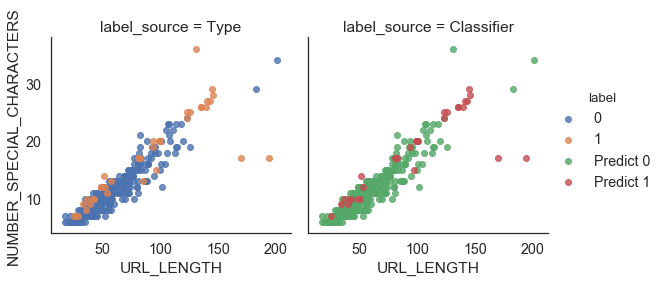

In [326]:
comparePlot(X_test, "Type","predicted_rf_tree")

# Tune the model and change "folds" for Random Forest classifiers

In [327]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 5, 7, 9],
    
             }
grid_clf = GridSearchCV(website_rf_model, param_grid, cv=10)
grid_clf.fit(X_train,Y_train)
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 20}

grid_clf = GridSearchCV(website_rf_model, param_grid, cv=10)
grid_clf.fit(X_train,Y_train)

In [328]:
# change n_estimators according to the best params

X = website.loc[:, website.columns != 'Type']
Y = website.loc[:, website.columns == 'Type']

X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=0)
columns=X_train.columns

website_rf_model_cv1 = skens.RandomForestClassifier(n_estimators=20,oob_score=True, criterion='entropy')
website_rf_model_cv1.fit(X_train,Y_train)

predicted_labels_cv1 = website_rf_model_cv1.predict(X_test)
X_test['predicted_rf_tree_cv1'] = predicted_labels_cv1

accuracy_cv1 = accuracy_score(Y_test,predicted_labels_cv1)
print('Accuracy_cv1: {0: .2%}'.format(accuracy_cv1))

Accuracy_cv1:  96.56%


In [329]:
# change the folds to 3
grid_clf = GridSearchCV(website_rf_model, param_grid, cv=3)
grid_clf.fit(X_train,Y_train)
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 20}

In [330]:
# change max_depth and n_estimators according to the best params of cv=3

X = website.loc[:, website.columns != 'Type']
Y = website.loc[:, website.columns == 'Type']

X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=0)
columns=X_train.columns

website_rf_model_cv3 = skens.RandomForestClassifier(n_estimators=5,oob_score=True, criterion='entropy')
website_rf_model_cv3.fit(X_train,Y_train)

predicted_labels_cv3 = website_rf_model_cv3.predict(X_test)
X_test['predicted_rf_tree_cv3'] = predicted_labels_cv3

accuracy_cv3 = accuracy_score(Y_test,predicted_labels_cv3)
print('Accuracy_cv3: {0: .2%}'.format(accuracy_cv3))

Accuracy_cv3:  95.50%


In [331]:
# change the folds to 15
grid_clf = GridSearchCV(website_rf_model, param_grid, cv=15)
grid_clf.fit(X_train,Y_train)
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 20}

In [332]:
X = website.loc[:, website.columns != 'Type']
Y = website.loc[:, website.columns == 'Type']

X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=0)
columns=X_train.columns

website_rf_model_cv2 = skens.RandomForestClassifier(n_estimators=15,oob_score=True, criterion='entropy')
website_rf_model_cv2.fit(X_train,Y_train)

predicted_labels_cv2 = website_rf_model_cv2.predict(X_test)
X_test['predicted_rf_tree_cv2'] = predicted_labels_cv2

accuracy_cv2 = accuracy_score(Y_test,predicted_labels_cv2)
print('Accuracy_cv2: {0: .2%}'.format(accuracy_cv2))

Accuracy_cv2:  96.56%


# Most important feature

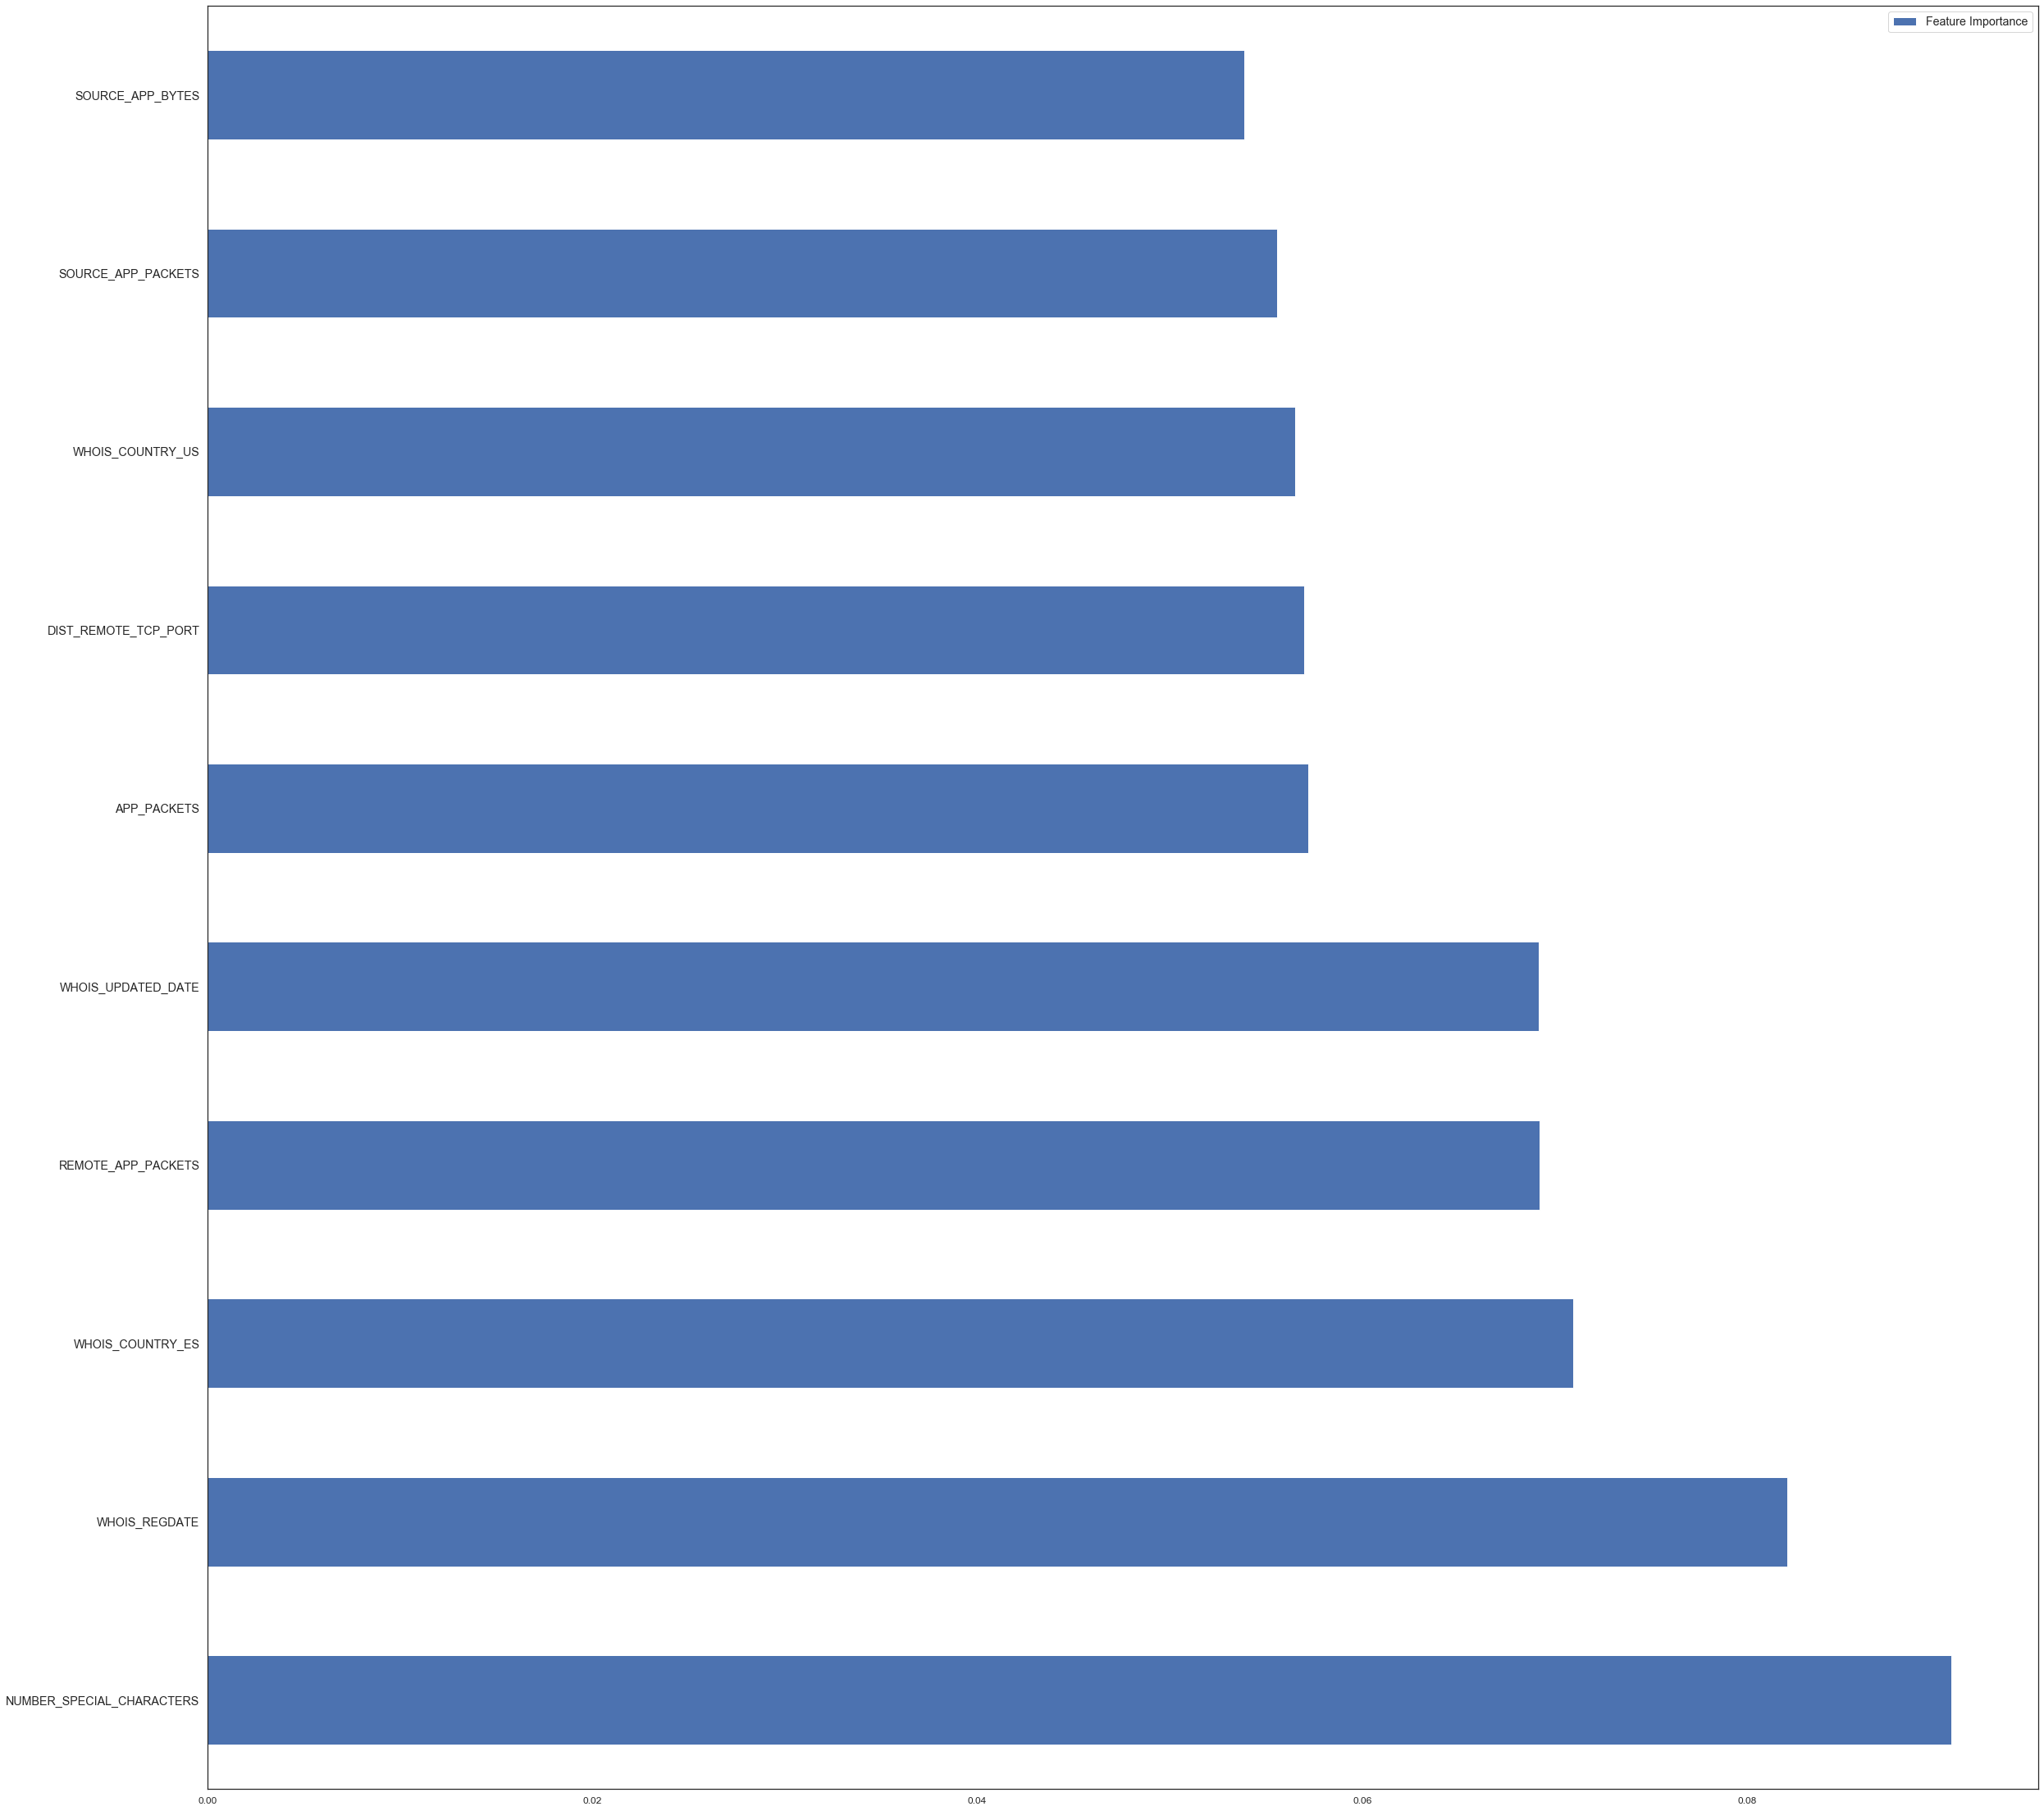

In [333]:
website_importance = website_rf_model.feature_importances_
matplotlib.rc('xtick', labelsize = 12)
pd.DataFrame({'Feature Importance':website_importance},
            index=X_train.columns[:]).sort_values(by = 'Feature Importance', ascending=False).head(10).plot(kind='barh',figsize=(40,40))



I finished all the required questions about random forest, and I will interpret my results one by one. 

Firstly, I created the random forest model. I set n_estimators=10, and got the accuracy of 97.35%. I also created the scatter point chart to compare visually, it seems majority of predicted points are consistent with the actual ones. Therefore, I'm happy with my model accuracy.

Then, I tuned the model by calling GridSearchCV function. I set the fold cv=10 initially, and I want to use the best_params_ result to change the model n_estimators=10. My assumtion is the n_estimators that best_params_ suggested would have highest accuracy rate. However, it seems not. The results for best_params_ of different folds are changing all the time, and the accuracy rate of the best_params_ seems even lower than that of my default n_estimators=10. Therefore I can't compare the results of different 'folds'. I could say all the accuracy rates are pretty close to each other, and high.

As for the important features, I need to explain my data manipulation in the first part first. The dummies function can transform the categorical data to numeric, by changing category values to columns. It's very not reasonable to change all the date to columns (will add the number of columns to thousands!). I was thinking of droping all the date related columns: WHOIS_REGDATE & WHOIS_UPDATED_DATE, I'm afraid they are important features. So I used toordinal to transform the date values to numerical values. I then checked the none value, and decide to drop all the none values. This will still leave me 1200+ rows to analyse. However, I did drop some columns: 'URL', 'SERVER', 'WHOIS_STATEPRO', 'CONTENT_LENGTH' and some duplicated columns of location. I know they could be important values, but they can be really messy after transformed to numerical data. Especially for example, 'WHOIS_STATEPRO' has no uniformed forms for locations, like 'FL' and 'Barcelona'. But I left the 'WHOIS_COUNTRY' column alternatively to show location information, which is less messy. 

I believe there are many different approaches to manipulate the dataset, and the important features and model calculation can be very different. In my approach, the most important feature is SOURCE_APP_BYTES, which is reasonable, that the size of the application can be important to predict whether the app is malicious or benign.

To prove my assumption, I run some codes as below:


In [334]:
website.groupby('Type').SOURCE_APP_BYTES.mean()

Type
0    17568.938117
1     7224.739437
Name: SOURCE_APP_BYTES, dtype: float64

In [335]:
website1= website
website1['log'] = np.log(website1.SOURCE_APP_BYTES+1)

(array([ 0.,  0.,  0.,  0.,  0.,  0., 60., 14.,  9., 10., 11.,  9., 14.,
         6.,  9.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  ]),
 <a list of 20 Patch objects>)

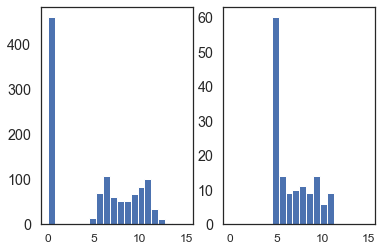

In [336]:
f, (ax1, ax2) = plt.subplots(1, 2)
website0 = website1[website1['Type']==0]
website2 = website1[website1['Type']==1]
ax1.hist(website0['log'], range=[0,15], bins=20)
ax2.hist(website2['log'], range=[0,15], bins=20)

Firstly, by comparing the mean values of the 2 type websites, I found the benign websites usually have larger SOURCE_APP_BYTES than malicious ones. Then, I used histograms to check the distributions for 2 types websites, and it's quite clear that the SOURCE_APP_BYTES of benign websites all fall in the bins above 5, whereas there are a lot of malicious websites having SOURCE_APP_BYTES in the bins 0 or barely bigger than 0. The difference is quite obvious, which kind of facilitating the most important feature is SOURCE_APP_BYTES. The following important features, such as REMOTE_APP_BYTES and NUMBER_SPECIAL_CHARACTERS are reasonable based on the common sense as well.

# Naive Bayes

In [337]:
website.columns

Index(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type', 'CHARSET_ISO-8859-1',
       'CHARSET_UTF-8', 'CHARSET_iso-8859-1', 'CHARSET_us-ascii',
       'CHARSET_utf-8', 'CHARSET_windows-1251', 'CHARSET_windows-1252',
       'WHOIS_COUNTRY_AE', 'WHOIS_COUNTRY_AT', 'WHOIS_COUNTRY_AU',
       'WHOIS_COUNTRY_BE', 'WHOIS_COUNTRY_BS', 'WHOIS_COUNTRY_BY',
       'WHOIS_COUNTRY_CA', 'WHOIS_COUNTRY_CH', 'WHOIS_COUNTRY_CN',
       'WHOIS_COUNTRY_CZ', 'WHOIS_COUNTRY_DE', 'WHOIS_COUNTRY_ES',
       'WHOIS_COUNTRY_GB', 'WHOIS_COUNTRY_HK', 'WHOIS_COUNTRY_IE',
       'WHOIS_COUNTRY_IL', 'WHOIS_COUNTRY_IN', 'WHOIS_COUNTRY_IT',
       'WHOIS_COUNTRY_JP', 'WHOIS_COUNTRY_KG', 'WHOIS_COUNTRY_KY',
       'WHOIS_COUNTRY_LV', 'WHOIS_COUNTRY_NL', '

In [338]:
X = website.loc[:, website.columns != 'Type']
Y = website.loc[:, website.columns == 'Type']

In [339]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=0)
columns=X_train.columns

In [340]:
# train the model
gnb_model = sknb.GaussianNB()

gnb_model.fit(X_train[['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS','REMOTE_IPS' ]],Y_train['Type'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [341]:
# test the model
y_pred = gnb_model.predict(X_test[['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS','REMOTE_IPS']])

In [342]:
accuracy1=accuracy_score(Y_test,y_pred)
print('Accuracy: {0: .2%}'.format(accuracy1))

Accuracy:  89.42%


In [343]:
gnb_model.fit(X_train[['URL_LENGTH']],Y_train['Type'])
y_pred = gnb_model.predict(X_test[['URL_LENGTH']])
accuracy1=accuracy_score(Y_test,y_pred)
print('Accuracy: {0: .2%}'.format(accuracy1))

Accuracy:  89.68%


In [344]:
gnb_model.fit(X_train[['WHOIS_REGDATE', 'TCP_CONVERSATION_EXCHANGE','DNS_QUERY_TIMES' ]],Y_train['Type'])
y_pred = gnb_model.predict(X_test[['WHOIS_REGDATE', 'TCP_CONVERSATION_EXCHANGE','DNS_QUERY_TIMES' ]])
accuracy1=accuracy_score(Y_test,y_pred)
print('Accuracy: {0: .2%}'.format(accuracy1))

Accuracy:  87.83%


In [345]:
gnb_model.class_prior_

array([0.88964733, 0.11035267])

# experiment different prior number

In [346]:
gnb_model2 = sknb.GaussianNB(priors=[0.5,0.5])
gnb_model2.fit(X_train[['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS','REMOTE_IPS']],Y_train['Type'])
y_pred2 = gnb_model2.predict(X_test[['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS','REMOTE_IPS']])
accuracy2=accuracy_score(Y_test,y_pred2)
print('Accuracy: {0: .2%}'.format(accuracy2))

Accuracy:  81.48%


In [347]:
gnb_model2.class_prior_

array([0.5, 0.5])

In [348]:
gnb_model3 = sknb.GaussianNB(priors=[0.3,0.7])
gnb_model3.fit(X_train[['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS','REMOTE_IPS']],Y_train['Type'])
y_pred3 = gnb_model3.predict(X_test[['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS','REMOTE_IPS']])
accuracy3=accuracy_score(Y_test,y_pred3)
print('Accuracy: {0: .2%}'.format(accuracy3))

Accuracy:  70.37%


In [349]:
gnb_model3.class_prior_

array([0.3, 0.7])

I created Naive Bayes, and predited website types based on 'URL_LENGTH','NUMBER_SPECIAL_CHARACTERS' and 'REMOTE_IPS' features, and the accuracy rate is 89.42%. Interestingly, if I just use 'URL_LENGTH' feature to predict, the accuracy rate is slighter higher: 89.68%. Then I tried another feature combination: 'WHOIS_REGDATE', 'TCP_CONVERSATION_EXCHANGE' and 'DNS_QUERY_TIMES', getting a pretty similar accuracy rate 87.83%. I learned that the accuracy of combination of features is not necessarily higher than that of a single feature. 

By changing prior number, I found the default class prior value has the highest accuracy. 

# Final Thinking

Most time I spent on this homework is data cleaning. The original dataset only have 5.9 usability score. During the initial exploration of the dataset, I found there are lots of n/a value, or value as 'none', which makes drop n/a process complex. The values for location are messy and not in the uniformed format. The country names also have certain duplication that I need to combine columns. I tried to drop as less columns as I could, because I don't want to take the risk of dropping potential important features. 

After exploration of the 2 types of classification models, I can see the random forest seems has higher accruacy than Naive Bayes, which is reasonable, because I used all features in table for prediction in random forest model, while I only choose random feature or feature combinations for Naive Bayes model. I have questions about the best params function of random forest, since the change of number of folds/estimators seems not make many changes in accuracy, whereas, if I change prior number for Naive Bayes, the accuracy can be very different.

As for the detailed understanding of features, I mostly refer to the summaries of variables as below when I choose feature combinations for naive bayes model:

    • URL: anonymized URL which may or may not be malicious.
    • URL_LENGTH: Indicates number of characters in the URL.
    • NUMBER_SPECIAL_CHARACTERS: Indicates special characers in the URL.
    • CHARSET: It indicates the character encoding standard and is a categorical variable.
    • SERVER: It indicates the operative system of the server got from the packet response and is a categorical variable.
    • CONTENT_LENGTH: It indicates the content size of HTTP header.
    • WHOIS_COUNTRY: Using Whois API it indicates the Countries the server got a response and is a categorical variable.
    • WHOIS_STATEPRO: Using Whois API it indicates the States the server got a response and is a categorical variable.
    • WHOIS_REGDATE: It indicates the Whois server registration date.
    • WHOIS_UPDATED_DATE: It indicates the last update date from the server analyzed.
    • TCP_CONVERSATION_EXCHANGE: It indicates the number of TCP packets that were exchanged between the honeypot client and the server.
    • DIST_REMOTE_TCP_PORT: It indicates the number of ports detected.
    • REMOTE_IPS: It indicates the total number of IPs connected to honeypot client.
    • APP_BYTES: It indicates the number of bytes transfered.
    • SOURCE_APP_PACKETS: It indicates the packets sent from the honeypot to the server.
    • REMOTE_APP_PACKETS: It indicates the packets received from the server.
    • APP_PACKETS: It is the total number of IP packets generated during the communication between the honeypot and the server.
    • DNS_QUERY_TIMES: It indicates the number of DNS packets generated during the communication between the honeypot and the server.
    • TYPE: This is the outcome variable indicating whether the website is malicious or not.



So usually, malicious websites are more likely to have more NUMBER_SPECIAL_CHARACTERS, URL_LENGTH, DNS_QUERY_TIMES, and smaller APP_BYTES and SOURCE_APP_PACKETS. In the future, I want to learn how to visualize to compare the predition with actual values for naive bayes model.